In [ ]:
# # !pip download zarr --quiet # run this once, with internet
# # download and upload as dataset
# ! mkdir -p /kaggle/working/asciitree
# ! cp /kaggle/input/d/etiennedoumazane/asciitree/asciitree-0.3.3.tar.gz_ /kaggle/working/asciitree/asciitree-0.3.3.tar.gz
# ! pip install asciitree --no-index --find-links /kaggle/working/asciitree --quiet
# ! pip install zarr --no-index --find-links /kaggle/input/zarr-dependencies --quiet

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path
import pandas as pd
import zarr
import sys
from skimage.feature import peak_local_max
import dask.array as da
import numpy as np
from dask_image import ndfilters
from matplotlib import pyplot as plt

src_dir = os.environ.get('SRC_DIR')
if src_dir and src_dir not in sys.path:
    sys.path.append(src_dir)


kaggle_data_dir = '/kaggle/input/czii-cryo-et-object-identification'
data_dir = Path(os.environ.get("DATA_DIR", kaggle_data_dir))

PARTICLE_TYPES = ['apo-ferritin',
 'beta-galactosidase',
 'ribosome',
 'thyroglobulin',
 'virus-like-particle']

FREQUENCIES = {
    "apo-ferritin": 0.3,
    "beta-galactosidase": 0.1,
    "ribosome": 0.3,
    "thyroglobulin": 0.2,
    "virus-like-particle": 0.1
}

SCALE = (10, 10, 10)

def generate_experiment_list(data_dir):
    return os.listdir(data_dir / 'train/static/ExperimentRuns')

def generate_path_list(data_dir):
    experiments = generate_experiment_list(data_dir)
    return [data_dir / f'train/static/ExperimentRuns/{experiment}/VoxelSpacing10.000/denoised.zarr' for experiment in experiments]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def preprocess(arr, params):
    arr = ndfilters.median_filter(arr, size=params.get("median_filter_size", 3))
    arr = ndfilters.gaussian_filter(arr, sigma=params.get("gaussian_filter_sigma", 1))
    return 1 - arr

def get_coordinates(arr, params):
    arr = arr.compute() # doesn't support peak_local_max
    print("Preprocessing done")
    coordinates = peak_local_max(arr, min_distance=params.get("min_distance", 5),
                                 threshold_abs=params.get("threshold_abs", 0.5))
    coordinates = coordinates * SCALE
    print("Coordinates extracted")
    return coordinates[:,::-1]

def generate_random_particle_list(n_particles):
    particles = []
    for _ in range(n_particles):
        particle_type = np.random.choice(list(FREQUENCIES.keys()), p=list(FREQUENCIES.values()))
        particles.append(particle_type)
    return particles

def get_table(path, params):
    print(f"Processing {path}")
    arr = da.array(zarr.open(path)[0])
    arr = preprocess(arr, params)
    coordinates = get_coordinates(arr, params)
    particles = generate_random_particle_list(len(coordinates))
    df = pd.DataFrame(coordinates, columns=["x", "y", "z"])
    df["experiment"] = path.parts[-3]
    df["particle_type"] = particles
    return df


def get_result_table(data_dir, params):
    paths = generate_path_list(data_dir)
    tables = [get_table(path, params) for path in paths]
    table = pd.concat(tables)
    table = table.reset_index(drop=False).rename(columns={"index": "id"})
    return table

In [ ]:
# process one
paths = generate_path_list(data_dir)
params = {
    "median_filter_size": 3,
    "gaussian_filter_sigma": 5,
    "min_distance": 5,
    "threshold_abs": 1 - 2e-5
}
arr = da.array(zarr.open(paths[0])[0])
arr = preprocess(arr, params)
coordinates = get_coordinates(arr, params)
len(coordinates)


Preprocessing done
Coordinates extracted


In [ ]:
# process all

params = {
    "median_filter_size": 3,
    "gaussian_filter_sigma": 5,
    "min_distance": 5,
    "threshold_abs": 1 - 2e-5
}
result_table = get_result_table(data_dir, params)
result_table.to_csv("result_table.csv", index=False)

Processing /data/etienne.doumazane/kaggle/cryoet/data/train/static/ExperimentRuns/TS_5_4/VoxelSpacing10.000/denoised.zarr
Preprocessing done
Coordinates extracted
Coordinates extracted
Processing /data/etienne.doumazane/kaggle/cryoet/data/train/static/ExperimentRuns/TS_69_2/VoxelSpacing10.000/denoised.zarr
Preprocessing done
Coordinates extracted
Coordinates extracted
Processing /data/etienne.doumazane/kaggle/cryoet/data/train/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr
Preprocessing done
Coordinates extracted
Coordinates extracted
Processing /data/etienne.doumazane/kaggle/cryoet/data/train/static/ExperimentRuns/TS_6_6/VoxelSpacing10.000/denoised.zarr
Preprocessing done
Coordinates extracted
Coordinates extracted
Processing /data/etienne.doumazane/kaggle/cryoet/data/train/static/ExperimentRuns/TS_73_6/VoxelSpacing10.000/denoised.zarr
Preprocessing done
Coordinates extracted
Coordinates extracted
Processing /data/etienne.doumazane/kaggle/cryoet/data/train/static/Experi

In [ ]:
def plot_histograms(table):
    df = pd.read_csv(table)
    axi = plt.subplots(1, 3, figsize=(15, 5))[1].flat
    plt.suptitle(table)
    for axis in "xyz":
        plt.sca(next(axi))
        plt.title(axis)
        plt.hist(df[axis], bins=30)
    plt.show()

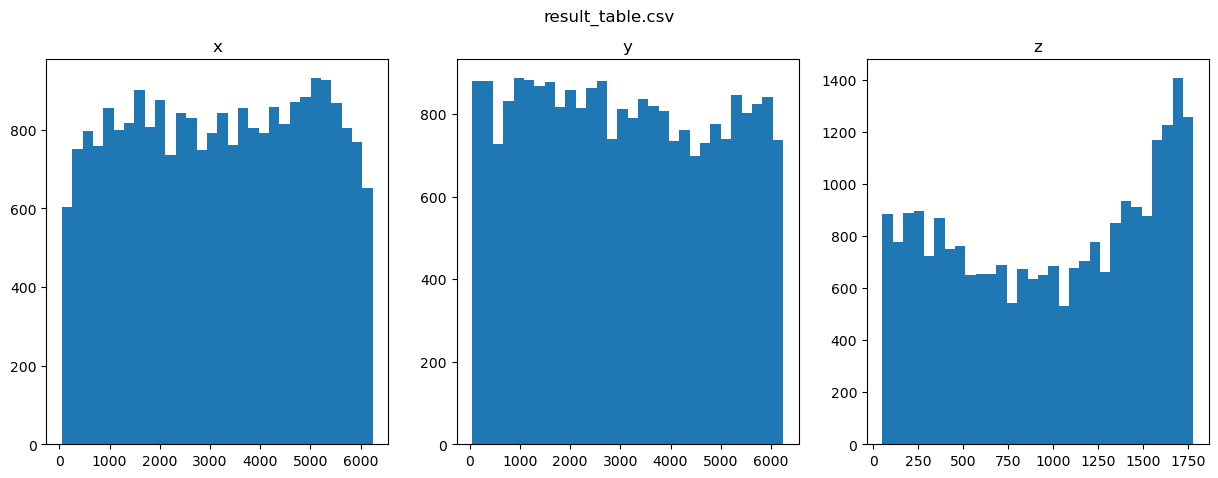

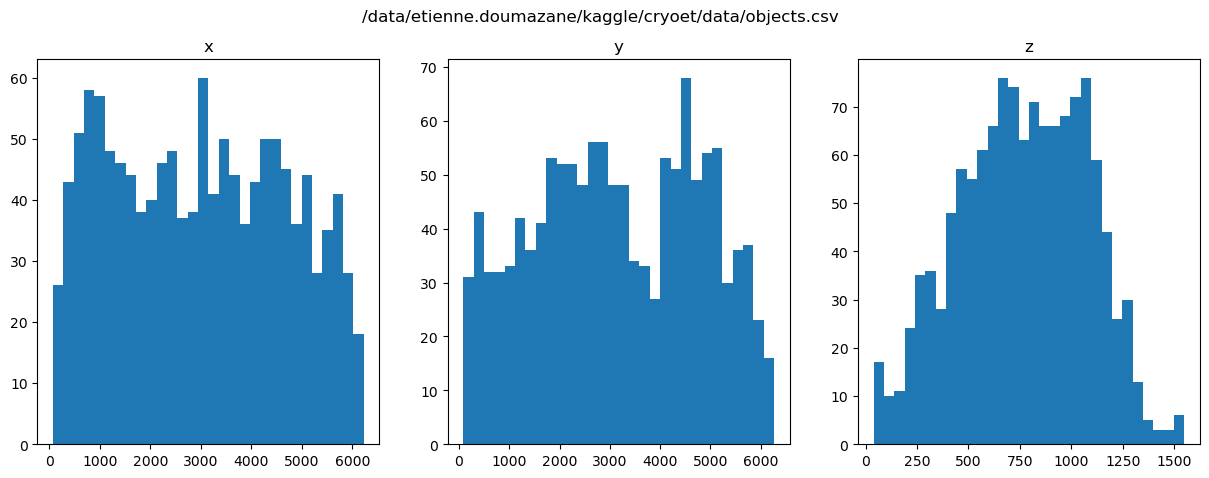

In [81]:
plot_histograms("result_table.csv")
plot_histograms(data_dir / "objects.csv")

In [ ]:
from metrics import compute_score
compute_score("result_table.csv", data_dir / "objects.csv")


0.07595668871854011